### Intro

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL.Image import open
import PIL
from IPython import display
from time import time, sleep

import os
from glob import glob
from Img2Graph import *
from main import *

In [2]:
def segment_plot_color(G, img, img_seed, s=2):
    # initialize: S = {s}, T = {t}, A = {s, t}, O = ∅
    A = ['S','T']
    i = 0
    t = time()
    while True:
        if time() - t > s or i == 0:
            plt.figure(figsize=(15,7))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.subplot(131)
            plt.imshow(img)
            plt.subplot(132)
            plt.imshow(graph2img(G, *img.shape[:2]), cmap='seismic')
            plt.subplot(133)
            plt.imshow(img_seed)
            plt.show()
            t = time()
            i = 1
        # grow S or T to find an augmenting path P from s to t
        P = grow(G, A)
        # if P = ∅ terminate
        if not P:
            break
        # augment on P
        Orphans = augment(G, P)
        # adopt orphans
        A = adopt(G, Orphans, A)
    
    plt.figure(figsize=(15,7))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.subplot(131)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(graph2img(G, *img.shape[:2]), cmap='seismic')
    plt.subplot(133)
    plt.imshow(img_seed)
    plt.show()

    # end while
    return G


def segment_plot(G, img, img_seed, s=2):
    # initialize: S = {s}, T = {t}, A = {s, t}, O = ∅
    A = ['S','T']
    i = 0
    t = time()
    while True:
        if time() - t > s or i == 0:
            plt.figure(figsize=(15,7))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            plt.subplot(131)
            plt.imshow(img, cmap='gray')
            plt.subplot(132)
            plt.imshow(graph2img(G, *img.shape), cmap='seismic')
            plt.subplot(133)
            plt.imshow(img_seed, cmap='gray')
            plt.show()
            t = time()
            i = 1

        # grow S or T to find an augmenting path P from s to t
        P = grow(G, A)
        # if P = ∅ terminate
        if not P:
            break
        # augment on P
        Orphans = augment(G, P)
        # adopt orphans
        A = adopt(G, Orphans, A)
    
    plt.figure(figsize=(15,7))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.subplot(131)
    plt.imshow(img, cmap='gray')
    plt.subplot(132)
    plt.imshow(graph2img(G, *img.shape), cmap='seismic')
    plt.subplot(133)
    plt.imshow(img_seed, cmap='gray')
    plt.show()

    # end while
    return G


### Dog test

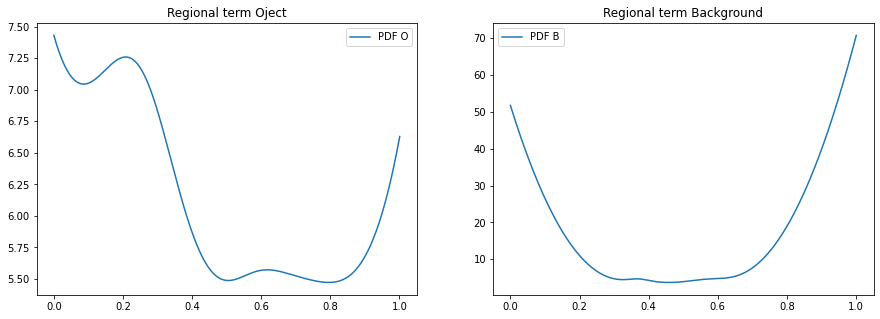

In [26]:
W, H = 50,50
img = np.array(open('images/dog_small.jpg').convert('L').resize((W, H))) / 255
img_painted = np.array(open('images/dog_small_ST.jpg').convert('RGB').resize((W, H)))

priors = initialize_priors(img_painted)
G, Rp = image2graph(img, *priors, prior_as_index=True, σ=.1, λ=.1)

N = 1000
X = np.linspace(0, 1 + 1/N, N)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Regional term Oject")
plt.plot(X, Rp["obj"](X), label='PDF O')
plt.legend()
plt.subplot(122)
plt.title("Regional term Background")
plt.plot(X, Rp["bkg"](X), label='PDF B')
plt.legend()
plt.show()

<Figure size 1080x504 with 0 Axes>

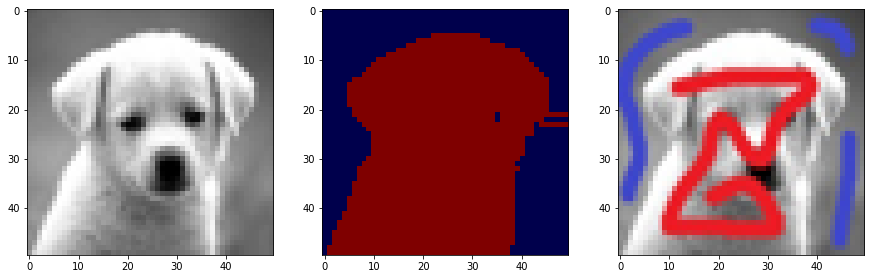

In [27]:
segment_plot(G, img, img_painted, s=1)

### Experiment data

#### Grayscale

In [31]:
paths = [path for path in glob(os.path.join("dataset",'images',"*.jpg"))]
images = [open(path).convert('L') for path in paths]
groundtruths = [open(path.replace('.jpg', '.png').replace('images','images-gt')).convert('L') for path in paths]
labels = [open(path.replace('.jpg', '-anno.png').replace('images','images-labels')) for path in paths]

In [ ]:
idx = 7
n, p = images[0].size
W, H = n//4, p//4
img = np.array(images[idx].resize((W,H))) / 255
gt = np.array(groundtruths[idx].resize((W,H), resample=PIL.Image.NEAREST))
label = np.array(labels[idx].resize((W,H), resample=PIL.Image.NEAREST))


priors = (label==1, label==2)
nbins = 30
G, probs = image2graph(img, *priors, nbins=nbins, alpha=100, λ=0.7, sig=30)

X = np.linspace(0, 1 + 1/(nbins+1), nbins+1)
plt.title("Priors distribution")
plt.plot(X, probs["obj"](X), label='PDF O')
plt.plot(X, probs["bkg"](X), label='PDF B')
plt.legend()
plt.show()

In [ ]:
plt.imshow(gt)

In [ ]:
np.histogram([[1,2],[3,2],[4,1]])

In [ ]:
segment_plot(G, img, label, s=5)

In [ ]:
segment_plot(G, img, label, s=5)

#### Color

In [5]:
paths = [path for path in glob(os.path.join("dataset",'images',"*.jpg"))]
images = [open(path) for path in paths]
groundtruths = [open(path.replace('.jpg', '.png').replace('images','images-gt')).convert('L') for path in paths]
labels = [open(path.replace('.jpg', '-anno.png').replace('images','images-labels')) for path in paths]

In [28]:
idx = 1
n, p = images[0].size
W, H = n//4, p//4
img = np.array(images[idx].resize((W,H))) / 255
gt = np.array(groundtruths[idx].resize((W,H), resample=PIL.Image.NEAREST))
label = np.array(labels[idx].resize((W,H), resample=PIL.Image.NEAREST))


priors = (label==1, label==2)
G, Rp = image2graph(img, *priors,  λ=.1, σ=.1)


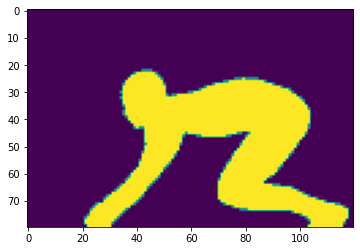

In [29]:
plt.imshow(gt)

<Figure size 1080x504 with 0 Axes>

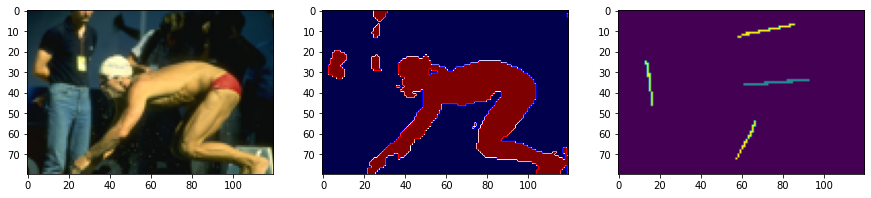

In [30]:
segment_plot_color(G, img, label, s=5)

In [33]:
segH, segW = graph2cuts(G, *img.shape[:2])

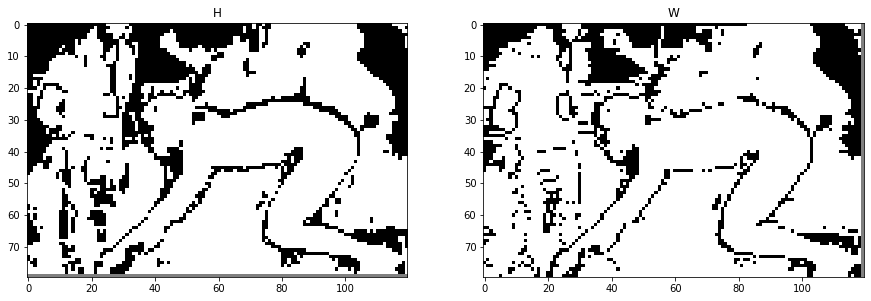

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("H")
plt.imshow(segH, cmap='gray')
plt.subplot(122)
plt.title("W")
plt.imshow(segW, cmap='gray')
plt.show()

In [83]:
def dice(gt, pred, with_contour=False):
    _gt = np.zeros_like(gt)
    _gt[gt==0] = -1
    _gt[gt==255] = 1
    if with_contour:
        return _dice((_gt>=0), (pred>=0))
    else:
        return _dice((_gt>0), (pred>0))

def _dice(x,y):
    return 2 * np.sum((x==1)*(y==1))/ (np.sum(x==1) + np.sum(y==1))

In [84]:
pred = - graph2img(G, *img.shape[:2])

In [86]:
dice(gt, pred)

0.8586475164572113